## Requirements

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional, Conv1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import math

## Dataset Preparation

In [31]:
df_train = pd.read_csv("data/data_train.csv", encoding='utf-8')
df_test = pd.read_csv("data/data_test.csv", encoding='utf-8')
print("Info data training awal:")
df_train.info()
print("\n")

Info data training awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 24336 non-null  int64  
 1   tanggal_waktu      24336 non-null  object 
 2   suhu               24336 non-null  float64
 3   beban_listrik      24336 non-null  float64
 4   kecepatan_angin    24336 non-null  float64
 5   tekanan_udara      24336 non-null  float64
 6   dampak_lingkungan  24336 non-null  object 
 7   konsumsi_listrik   24283 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.5+ MB




## Preprocessing

In [32]:
df_train["tanggal_waktu"] = pd.to_datetime(df_train["tanggal_waktu"])
df_test["tanggal_waktu"] = pd.to_datetime(df_test["tanggal_waktu"])

In [33]:
# Cek missing values
print(df_train.isnull().sum())

ID                    0
tanggal_waktu         0
suhu                  0
beban_listrik         0
kecepatan_angin       0
tekanan_udara         0
dampak_lingkungan     0
konsumsi_listrik     53
dtype: int64


In [34]:
# Isi missing values jika ada
df_train["tekanan_udara"] = df_train["tekanan_udara"].fillna(df_train["tekanan_udara"].interpolate())
df_train["konsumsi_listrik"] = df_train["konsumsi_listrik"].fillna(method="ffill")

print(df_train.isnull().sum())

ID                   0
tanggal_waktu        0
suhu                 0
beban_listrik        0
kecepatan_angin      0
tekanan_udara        0
dampak_lingkungan    0
konsumsi_listrik     0
dtype: int64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21360\1436221346.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train["konsumsi_listrik"] = df_train["konsumsi_listrik"].fillna(method="ffill")


In [35]:
# Encode dampak_lingkungan
df_train = pd.get_dummies(df_train, columns=["dampak_lingkungan"])
df_test = pd.get_dummies(df_test, columns=["dampak_lingkungan"])

df_train.head()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,konsumsi_listrik,dampak_lingkungan_A,dampak_lingkungan_B,dampak_lingkungan_C
0,0,2021-09-17 00:00:00,15.9,-17.1,571.910,1003.0,216.0,True,False,False
1,1,2021-09-17 01:00:00,15.5,-19.3,575.040,996.0,210.0,True,False,False
2,2,2021-09-17 02:00:00,15.1,-20.0,578.435,1000.0,225.0,True,False,False
3,3,2021-09-17 03:00:00,15.9,-17.1,582.580,995.0,216.0,True,False,False
4,4,2021-09-17 04:00:00,15.9,-19.3,586.600,1005.0,222.0,True,False,False


In [36]:
# Sort sesuai dengan tanggal_waktu
df_cleaned = df_train.sort_values("tanggal_waktu")
df_test = df_test.sort_values("tanggal_waktu")
df_cleaned.head()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,konsumsi_listrik,dampak_lingkungan_A,dampak_lingkungan_B,dampak_lingkungan_C
0,0,2021-09-17 00:00:00,15.9,-17.1,571.910,1003.0,216.0,True,False,False
1,1,2021-09-17 01:00:00,15.5,-19.3,575.040,996.0,210.0,True,False,False
2,2,2021-09-17 02:00:00,15.1,-20.0,578.435,1000.0,225.0,True,False,False
3,3,2021-09-17 03:00:00,15.9,-17.1,582.580,995.0,216.0,True,False,False
4,4,2021-09-17 04:00:00,15.9,-19.3,586.600,1005.0,222.0,True,False,False


In [37]:
# Cek outlier
df_cleaned.describe()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,konsumsi_listrik
count,24336.000000,24336,24336.000000,24336.000000,24336.000000,24336.000000,24336.000000
mean,16027.381657,2023-07-16 19:22:53.964496896,25.161082,-1.783510,23.631823,986.012964,531.997411
min,0.000000,2021-09-17 00:00:00,12.700000,-32.900000,1.075000,953.000000,174.000000
25%,8051.750000,2022-08-18 11:45:00,21.100000,-10.700000,3.165000,977.000000,219.000000
50%,16079.500000,2023-07-18 23:30:00,25.800000,-1.400000,6.670000,986.000000,270.000000
75%,24155.250000,2024-06-19 11:15:00,29.400000,7.900000,22.700000,995.000000,342.000000
max,32183.000000,2025-05-19 23:00:00,35.300000,18.600000,586.600000,1024.000000,99999.000000
std,9299.957517,NaN,4.888658,10.521302,46.781818,12.130831,4820.776434


In [38]:
df_train_interpolated = df_cleaned.copy()

# 1. Hitung batas atas
Q1 = df_train_interpolated['konsumsi_listrik'].quantile(0.25)
Q3 = df_train_interpolated['konsumsi_listrik'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# 2. Ganti outlier dengan NaN
df_train_interpolated.loc[df_train_interpolated['konsumsi_listrik'] > upper_bound, 'konsumsi_listrik'] = np.nan

# 3. Lakukan interpolasi berbasis waktu
df_train_interpolated.set_index('tanggal_waktu', inplace=True)
df_train_interpolated['konsumsi_listrik'].interpolate(method='time', inplace=True)
df_train_interpolated.reset_index(inplace=True) # Kembalikan index seperti semula

print("Proses Interpolasi selesai. Gunakan 'df_train_interpolated' untuk training.")

df_train_interpolated.info()

Proses Interpolasi selesai. Gunakan 'df_train_interpolated' untuk training.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   tanggal_waktu        24336 non-null  datetime64[ns]
 1   ID                   24336 non-null  int64         
 2   suhu                 24336 non-null  float64       
 3   beban_listrik        24336 non-null  float64       
 4   kecepatan_angin      24336 non-null  float64       
 5   tekanan_udara        24336 non-null  float64       
 6   konsumsi_listrik     24336 non-null  float64       
 7   dampak_lingkungan_A  24336 non-null  bool          
 8   dampak_lingkungan_B  24336 non-null  bool          
 9   dampak_lingkungan_C  24336 non-null  bool          
dtypes: bool(3), datetime64[ns](1), float64(5), int64(1)
memory usage: 1.4 MB


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21360\3510887517.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_interpolated['konsumsi_listrik'].interpolate(method='time', inplace=True)


In [39]:
# Menambahkan fitur-fitur baru dari kolom `tanggal_waktu` untuk memberikan lebih banyak informasi kepada model.
def feature_engineer(df):
    df['hour'] = df['tanggal_waktu'].dt.hour
    df['day_of_week'] = df['tanggal_waktu'].dt.dayofweek
    df['day_of_year'] = df['tanggal_waktu'].dt.dayofyear
    df['month'] = df['tanggal_waktu'].dt.month

    # Fitur Siklikal untuk jam
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    df = df.drop('hour', axis=1)
    # Tidak perlu get_dummies karena sudah ada dampak_lingkungan_A/B/C
    return df

df_train_featured = feature_engineer(df_train_interpolated)
df_test_featured = feature_engineer(df_test)
print("Data setelah feature engineering:")
print(df_train_featured.head())
print("\n")

Data setelah feature engineering:
        tanggal_waktu  ID  suhu  beban_listrik  kecepatan_angin  \
0 2021-09-17 00:00:00   0  15.9          -17.1          571.910   
1 2021-09-17 01:00:00   1  15.5          -19.3          575.040   
2 2021-09-17 02:00:00   2  15.1          -20.0          578.435   
3 2021-09-17 03:00:00   3  15.9          -17.1          582.580   
4 2021-09-17 04:00:00   4  15.9          -19.3          586.600   

   tekanan_udara  konsumsi_listrik  dampak_lingkungan_A  dampak_lingkungan_B  \
0         1003.0             216.0                 True                False   
1          996.0             210.0                 True                False   
2         1000.0             225.0                 True                False   
3          995.0             216.0                 True                False   
4         1005.0             222.0                 True                False   

   dampak_lingkungan_C  day_of_week  day_of_year  month  hour_sin  hour_cos  
0   

In [40]:
# Menyiapkan data final untuk model
test_ids = df_test_featured['ID'].copy()

df_train_final = df_train_featured.drop(['ID', 'tanggal_waktu'], axis=1)
df_test_final = df_test_featured.drop(['ID', 'tanggal_waktu'], axis=1)

In [41]:
# Pastikan kolom train dan test sama persis
train_cols = df_train_final.drop('konsumsi_listrik', axis=1).columns
test_cols = df_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    df_test_final[c] = 0
    
df_test_final = df_test_final[train_cols]

In [42]:
print("--- Menambahkan Fitur Rolling Window ---")
def create_rolling_features(df):
    # Urutkan berdasarkan waktu untuk memastikan rolling window benar
    df = df.sort_values('tanggal_waktu').reset_index(drop=True)
    
    features_to_roll = ['suhu', 'beban_listrik', 'kecepatan_angin', 'tekanan_udara']
    window_sizes = [3, 6, 12] # Jendela waktu 3, 6, dan 12 jam
    
    for window in window_sizes:
        for col in features_to_roll:
            df[f'{col}_roll_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
            df[f'{col}_roll_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
            
    # Isi NaN yang muncul di awal data dari proses rolling
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

df_train_featured = create_rolling_features(df_train_featured)
df_test_featured = create_rolling_features(df_test_featured)

print("Data setelah feature engineering lanjutan:")
print(df_train_featured.head())
print("\n")


--- Menambahkan Fitur Rolling Window ---
Data setelah feature engineering lanjutan:
        tanggal_waktu  ID  suhu  beban_listrik  kecepatan_angin  \
0 2021-09-17 00:00:00   0  15.9          -17.1          571.910   
1 2021-09-17 01:00:00   1  15.5          -19.3          575.040   
2 2021-09-17 02:00:00   2  15.1          -20.0          578.435   
3 2021-09-17 03:00:00   3  15.9          -17.1          582.580   
4 2021-09-17 04:00:00   4  15.9          -19.3          586.600   

   tekanan_udara  konsumsi_listrik  dampak_lingkungan_A  dampak_lingkungan_B  \
0         1003.0             216.0                 True                False   
1          996.0             210.0                 True                False   
2         1000.0             225.0                 True                False   
3          995.0             216.0                 True                False   
4         1005.0             222.0                 True                False   

   dampak_lingkungan_C  ...  tek

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21360\3911206054.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21360\3911206054.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21360\3911206054.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21360\3911206054.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


## EDA

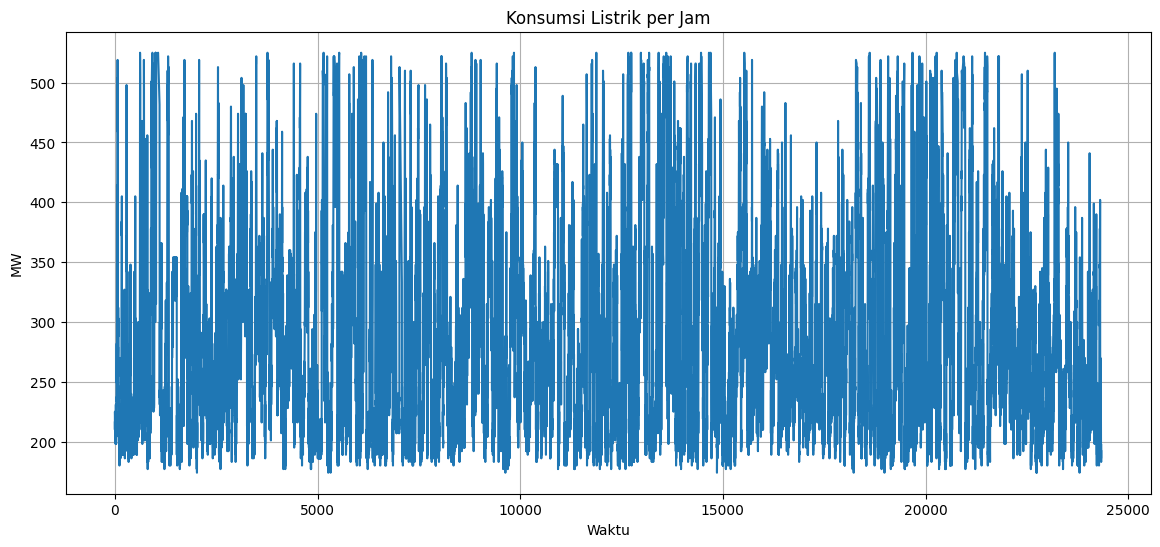

In [43]:
plt.figure(figsize=(14,6))
plt.plot(df_train_final.index, df_train_final['konsumsi_listrik'])
plt.title("Konsumsi Listrik per Jam")
plt.xlabel("Waktu")
plt.ylabel("MW")
plt.grid(True)
plt.show()

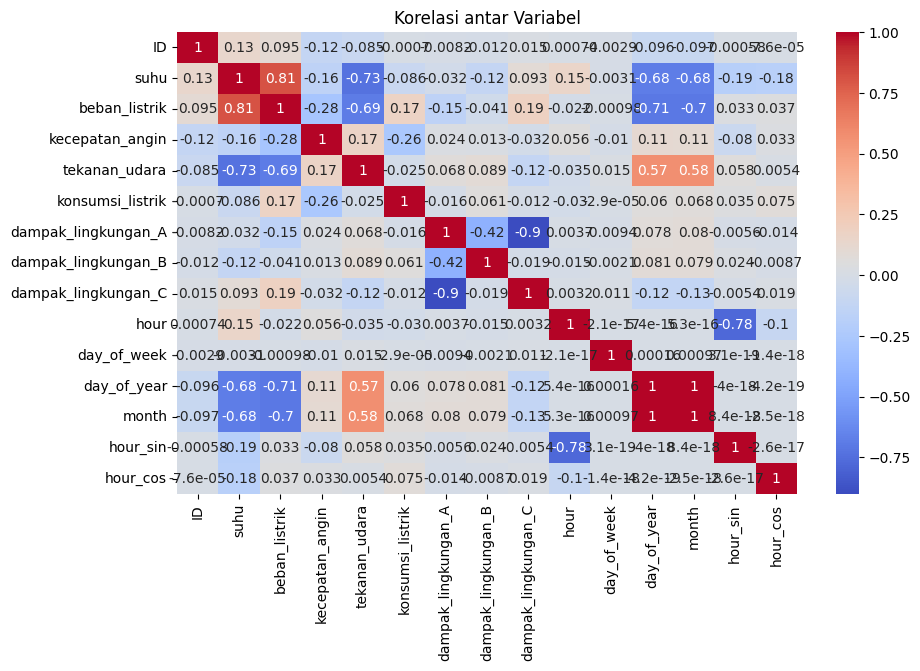

In [44]:
# Korelasi antar fitur
plt.figure(figsize=(10,6))
sns.heatmap(df_train_interpolated.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Korelasi antar Variabel")
plt.show()

## Modelling

### GRU

In [45]:
# Pisahkan fitur (X) dan target (y)
X = df_train_final.drop('konsumsi_listrik', axis=1).values
y = df_train_final['konsumsi_listrik'].values.reshape(-1, 1)

In [46]:
# Scaling fitur dan target secara terpisah
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [47]:
# Fungsi untuk membuat sekuens data untuk model RNN
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        if y is not None:
            ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24 # Menggunakan data 24 jam sebelumnya untuk prediksi

X_seq, y_seq = create_dataset(X_scaled, y_scaled, TIME_STEPS)

In [48]:
# Split data menjadi training dan validation set
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)
print(f"Bentuk data training: {X_train.shape}")
print(f"Bentuk data validasi: {X_val.shape}\n")

Bentuk data training: (19449, 24, 12)
Bentuk data validasi: (4863, 24, 12)



In [49]:
print("--- Membangun Model Hibrida Conv1D-GRU ---")
model_hybrid = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.2),
    
    Bidirectional(GRU(units=64, return_sequences=True)),
    Dropout(0.3),
    
    Bidirectional(GRU(units=32)),
    Dropout(0.3),
    
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

optimizer = Adam(learning_rate=0.001)
model_hybrid.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])
model_hybrid.summary()

--- Membangun Model Hibrida Conv1D-GRU ---


C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 22, 64)         │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 22, 128)        │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,761 (335.00 KB)

 Trainable params: 85,633 (334.50 KB)

 Non-trainable params: 128 (512.00 B)

In [50]:
# Training
print("\n--- Memulai Training Model ---")
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model_hybrid.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64, # Batch size sedikit lebih besar
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


--- Memulai Training Model ---
Epoch 1/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0784 - mean_absolute_percentage_error: 27226.0137 - val_loss: 0.0531 - val_mean_absolute_percentage_error: 97034.0000 - learning_rate: 0.0010
Epoch 2/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0398 - mean_absolute_percentage_error: 54084.2305 - val_loss: 0.0386 - val_mean_absolute_percentage_error: 146657.9219 - learning_rate: 0.0010
Epoch 3/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0357 - mean_absolute_percentage_error: 69627.0938 - val_loss: 0.0392 - val_mean_absolute_percentage_error: 112207.0156 - learning_rate: 0.0010
Epoch 4/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0329 - mean_absolute_percentage_error: 84472.4844 - val_loss: 0.0405 - val_mean_absolute_percentage_error: 134039.9531 - learning_rate: 0.0010
Epoch 5/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0319 - mean_absolute_percentage_error: 41540.5664 - val_loss: 0.0353 - val_m

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


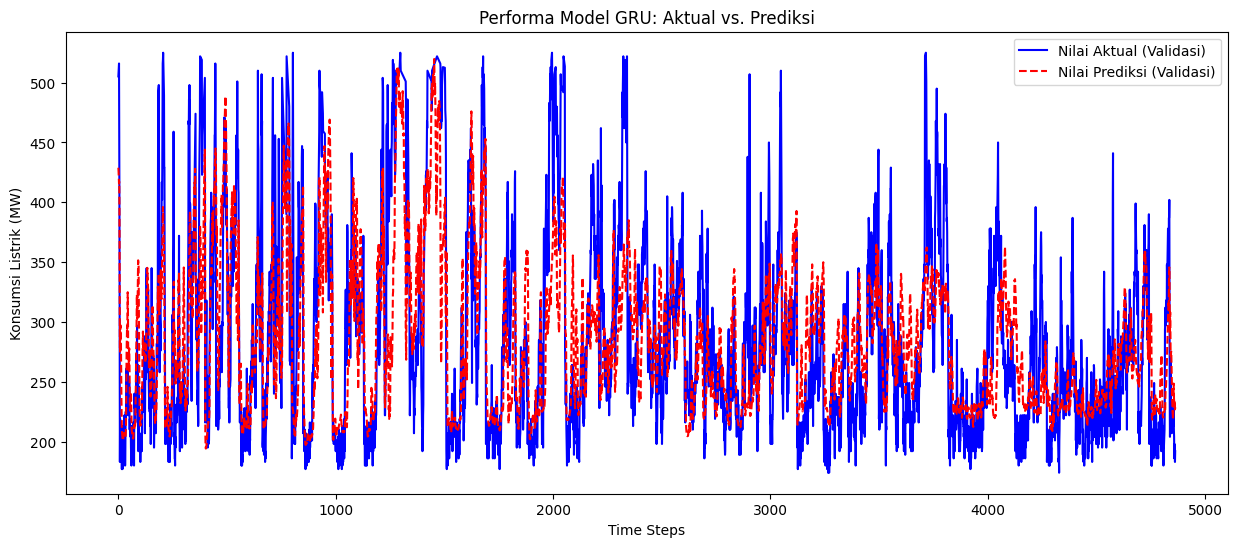

In [51]:
# Pastikan y_val_actual dan val_predictions sudah terdefinisi
y_val_actual = scaler_y.inverse_transform(y_val)
val_predictions_scaled = model_hybrid.predict(X_val)
val_predictions = scaler_y.inverse_transform(val_predictions_scaled)

# Visualisasi hasil pada data validasi
plt.figure(figsize=(15, 6))
plt.plot(y_val_actual, label='Nilai Aktual (Validasi)', color='blue')
plt.plot(val_predictions, label='Nilai Prediksi (Validasi)', color='red', linestyle='--')
plt.title('Performa Model GRU: Aktual vs. Prediksi')
plt.xlabel('Time Steps')
plt.ylabel('Konsumsi Listrik (MW)')
plt.legend()
plt.show()

## Evaluasi

In [52]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

def evaluate_model(df_test, forecast):
    mse = mean_squared_error(df_test, forecast)
    rmse = np.sqrt(mse)
    r2 = r2_score(df_test, forecast)
    mape = mean_absolute_percentage_error(df_test, forecast)
    
    print("\nMetrik Evaluasi pada Data Validasi:")
    print(f'MSE = {mse:.4f}')
    print(f'RMSE = {rmse:.4f}')
    print(f'R² = {r2:.4f}')
    print(f'MAPE = {mape:.4f}')

# ### Evaluasi
print("\n--- Mengevaluasi Model ---")
val_predictions_scaled = model_hybrid.predict(X_val)
val_predictions = scaler_y.inverse_transform(val_predictions_scaled)
y_val_actual = scaler_y.inverse_transform(y_val)

evaluate_model(y_val_actual, val_predictions)


--- Mengevaluasi Model ---
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Metrik Evaluasi pada Data Validasi:
MSE = 3562.2961
RMSE = 59.6850
R² = 0.5348
MAPE = 0.1485


In [53]:
# Evaluasi
print("\n--- Mengevaluasi Model ---")
val_predictions_scaled = model_hybrid.predict(X_val)
val_predictions = scaler_y.inverse_transform(val_predictions_scaled)
y_val_actual = scaler_y.inverse_transform(y_val)

rmse_val = math.sqrt(mean_squared_error(y_val_actual, val_predictions))
print(f'Validation RMSE (GRU Model): {rmse_val:.4f}')


--- Mengevaluasi Model ---
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation RMSE (GRU Model): 59.6850


## Prediction

In [ ]:
# Membuat File Submission
print("\n--- Membuat Prediksi untuk Data Test ---")
X_test_scaled = scaler_X.transform(df_test_final.values)

combined_data = np.concatenate([X_scaled[-TIME_STEPS:], X_test_scaled])

X_test_seq = []
for i in range(len(X_test_scaled)):
    X_test_seq.append(combined_data[i:i + TIME_STEPS])

X_test_seq = np.array(X_test_seq)

test_predictions_scaled = model_hybrid.predict(X_test_seq)
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)

# Buat dataframe untuk submission
submission_df = pd.DataFrame({'ID': test_ids, 'konsumsi_listrik': test_predictions.flatten()})
submission_df.to_csv('submission_gru_conv1d.csv', index=False)

print("\nFile submission 'submission_gru_conv1d.csv' berhasil dibuat.")
print(submission_df.head())


--- Membuat Prediksi untuk Data Test ---
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

File submission 'submission_gru_conv1d.csv' berhasil dibuat.
      ID  konsumsi_listrik
0  32184        230.144958
1  32185        233.802078
2  32186        229.324112
3  32187        223.679794
4  32188        225.545212



--- Menampilkan Visualisasi Prediksi pada Data Test ---


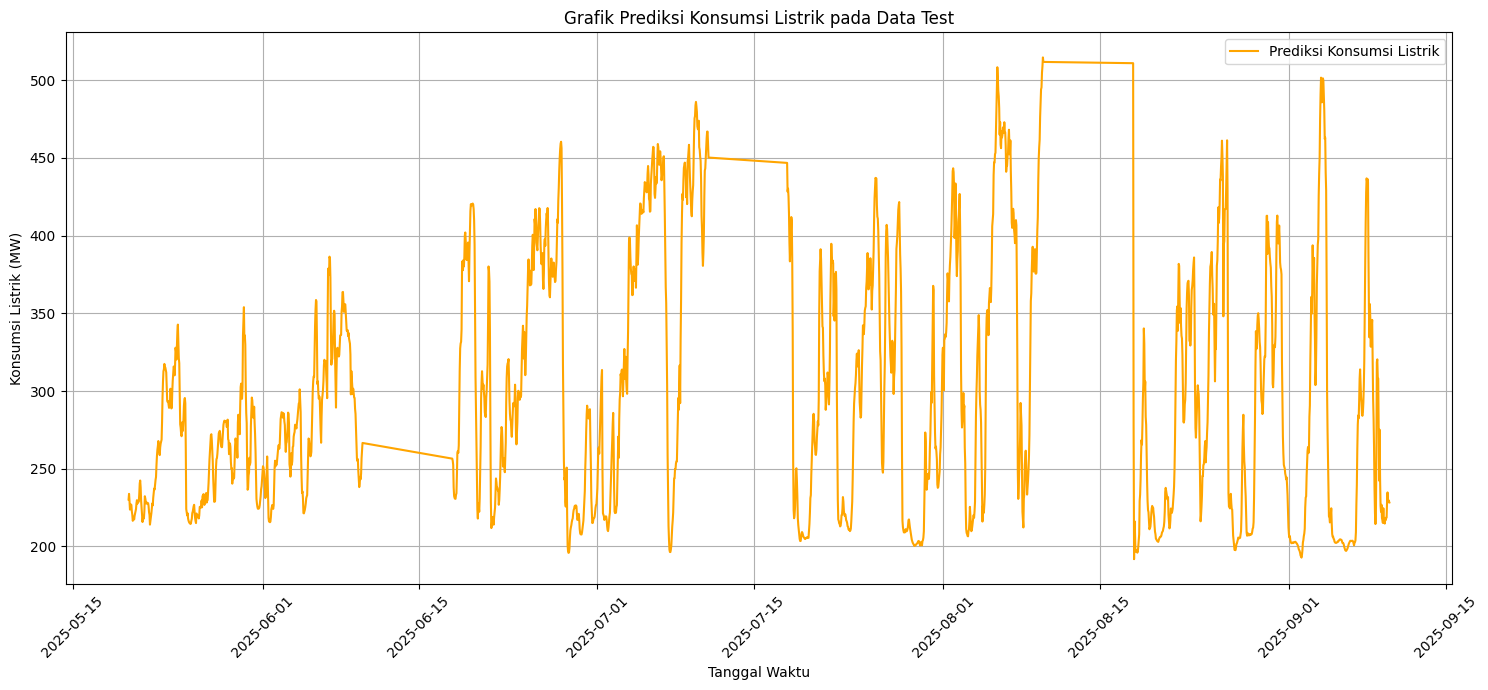

In [55]:
print("\n--- Menampilkan Visualisasi Prediksi pada Data Test ---")
plt.figure(figsize=(15, 7))
plt.plot(df_test['tanggal_waktu'], submission_df['konsumsi_listrik'], label='Prediksi Konsumsi Listrik', color='orange')
plt.title('Grafik Prediksi Konsumsi Listrik pada Data Test')
plt.xlabel('Tanggal Waktu')
plt.ylabel('Konsumsi Listrik (MW)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()